In [1]:
import os
import pandas as pd
import numpy as np
from google.cloud import storage
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import gc

In [2]:
JSONcredential = "key_storage_dl-orderbook.json"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = JSONcredential

In [3]:
#Create client to bundle configuration needed for API requests.
storage_client = storage.client.Client()

# Or create object to existing bucket
bucket = storage_client.get_bucket('bucket_l2_snapshot')

# blob = bucket.blob('l2_snapshot_100ms.csv')

In [30]:
df = pd.read_csv('gs://bucket_l2_snapshot/l2_snapshot_100ms.csv', index_col=0, infer_datetime_format=True)

In [31]:
df.index = pd.to_datetime(df.index)

In [32]:
def concat_data(base_path, features):
    """Concatenate all the files in basepath keeping only the
    columns specified by features.
    """
    l2_snapshot = pd.DataFrame()
    for i, x in enumerate(tqdm(sorted(os.listdir(base_path)))):
      if base_path is None:
        path = x
      else:
        path = base_path + x
      df_hour = pd.read_parquet(path, columns=features)
      l2_snapshot = pd.concat([l2_snapshot, df_hour.dropna()])
        
    return l2_snapshot

def extend_matrix(A, n):
    """Extend a matrix A by duplicating rows as specified by the list n."""
    n = n[1:]  # Do not duplicate rows for the first day
    A = A[:-1]  # Do not duplicate the last day's row
    A = np.repeat(A, repeats=n, axis=0)
    return A

def normalise_data_per_day(df):
    df_mean = df.resample('D').mean()
    df_var = df.resample('D').var()
    
    timestamps_per_day = np.unique(df.index.date, return_counts=True)[1]
    mean_array = extend_matrix(df_mean.to_numpy(), timestamps_per_day)
    var_array = extend_matrix(df_var.to_numpy(), timestamps_per_day)
    
    # Drop the rows of the first day
    df = df[df.index.date != df.index[0].date()]
    
    df = (df - mean_array) / np.sqrt(var_array)

    return df

def balance_classes(y):
    unique = np.unique(y, return_counts=True)

    # Take smallest number as class size
    class_size = np.min(unique[1])
    class_size_index = np.argmin(unique[1])
    timestamps = np.array([], dtype=int)
    for i, category in enumerate(unique[0]):
        if i == class_size_index:
            continue
        index = np.argwhere(y==category)
        index = index.reshape(len(index))
        random_timestamps = np.random.choice(index, (unique[1][i] - class_size), replace=False)
        timestamps = np.concatenate((timestamps, random_timestamps), axis=None)
        
    return timestamps

def generate_y(df_snapshot, T=100, D=40, best_ask='a1', best_bid='b1', k=20, alpha=10e-5):
    """Return X, y from the snapshot dataframe and the best ask/bid columns."""
    df = pd.DataFrame()
    df['mid_price'] = (df_snapshot[best_ask].to_numpy()+df_snapshot[best_bid].to_numpy())/2

    # Create columns delayed by -k to k-1
    for i in range(-k, k):
        df[i] = df['mid_price'].shift(periods=i)

    # Drop first k-1 rows and last k rows
    df.drop(range(0,20), axis=0, inplace=True)
    df.drop(range(len(df_snapshot)-20,len(df_snapshot)), axis=0, inplace=True)
    
    # Compute mean of previous k and next k
    df['m_b'] = df[range(0,20)].mean(axis=1)
    df['m_a'] = df[range(-20,0)].mean(axis=1)
    
    # Compute label of increasing or decreasing
    y_increase = np.where(df['m_b'] > df['m_a'] * (1+alpha), 1, 0)
    y_decrease = np.where(df['m_b'] < df['m_a'] * (1-alpha), -1, 0)
    y = y_increase + y_decrease

    # 100 most recent limit orders used so ignore first 100 timesteps
    y = y[T:]
    y += 1

    return y

def generate_preX(df_snapshot):
    # First and last 20 can't create labels for as previous and next k=20 needed
    preX = df_snapshot.to_numpy()[20:-20]

    return preX

def generate_X(preX, T=100, D=40):
    # For each timestep create matrix of 100 most recent limit orders
    X = np.array([preX[t:t+T] for t in range(len(preX)-T)], dtype='float32')
        
    return X

In [33]:
# takes 70 seconds
l2_norm = normalise_data_per_day(df)

In [34]:
del df

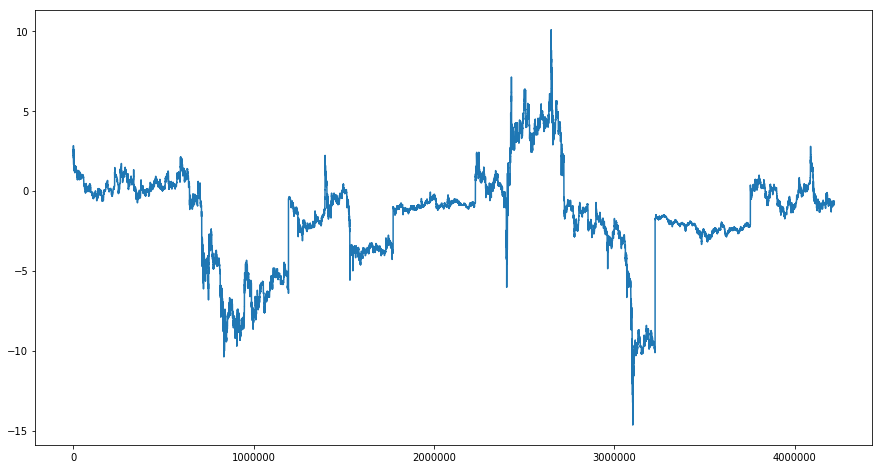

In [ ]:
# plt.figure(figsize = (15,8))
# plt.plot(np.arange(1,l2_norm.shape[0]+1), (l2_norm['a1']+l2_norm['b1'])/2)
# plt.show()

In [ ]:
# First create input dataset and then undersample to have balanced classes
# Train test validate split 

In [9]:
T = 100
D = 40
y = generate_y(l2_norm, T=T, D=D, best_ask='a1', best_bid = 'b1', alpha=0.002)
preX = generate_preX(l2_norm)
print("preX Shape: ", preX.shape)
X = generate_X(preX)
print("X shape, y shape: ", X.shape, y.shape)
print("Unique y's: ", np.unique(y))

del preX
gc.collect()

# First and last 20 are removed to create labels and then last 100 as previous 100 is required for input matrix
l2_norm_adj = l2_norm[20:-120]
X_index = l2_norm[20:-120].index

# Number of data points for the last day
num_test = np.unique(X_index.day, return_counts=True)[1][-1]

# Split the data into the first seven days and the last day
X_train_val = X[:-num_test]
y_train_val = y[:-num_test]
X_test = X[-num_test:]
y_test = y[-num_test:]
"""
# Balance out the classes by taking the number of the smallest class
timestamps_to_delete = balance_classes(y_train_val)
print("Number of snapshots deleted: ", len(timestamps_to_delete))
X_train_val = np.delete(X_train_val, timestamps_to_delete, axis=0)
y_train_val = np.delete(y_train_val, timestamps_to_delete, axis=0)
print("X_train_val shape and y_train_val shape", X_train_val.shape, y_train_val.shape)
print("The count for each class: ", np.unique(y_train_val, return_counts=True)[1])

# Split the data further (now randomly) into train and validation
X_train, X_validation, y_train, y_validation = train_test_split(
    X_train_val, y_train_val, test_size=0.15, random_state=42)

del X_train_val, y_train_val, X, y
gc.collect()
"""

preX Shape:  (4220032, 40)
X shape, y shape:  (4219932, 100, 40) (4219932,)
Unique y's:  [0 1 2]


'\n# Balance out the classes by taking the number of the smallest class\ntimestamps_to_delete = balance_classes(y_train_val)\nprint("Number of snapshots deleted: ", len(timestamps_to_delete))\nX_train_val = np.delete(X_train_val, timestamps_to_delete, axis=0)\ny_train_val = np.delete(y_train_val, timestamps_to_delete, axis=0)\nprint("X_train_val shape and y_train_val shape", X_train_val.shape, y_train_val.shape)\nprint("The count for each class: ", np.unique(y_train_val, return_counts=True)[1])\n\n# Split the data further (now randomly) into train and validation\nX_train, X_validation, y_train, y_validation = train_test_split(\n    X_train_val, y_train_val, test_size=0.15, random_state=42)\n\ndel X_train_val, y_train_val, X, y\ngc.collect()\n'

In [ ]:
print('X_train - Before: {} GB'.format(X_train.nbytes/1024**3), X_train.dtype)
print('y_train - Before: {} GB'.format(y_train.nbytes/1024**3), y_train.dtype)
print('X_validation - Before: {} GB'.format(X_validation.nbytes/1024**3), X_validation.dtype)
print('y_validation - Before: {} GB'.format(y_validation.nbytes/1024**3), y_validation.dtype)
print('X_test - Before: {} GB'.format(X_test.nbytes/1024**3), X_test.dtype)
print('y_test - Before: {} GB'.format(y_test.nbytes/1024**3), y_test.dtype)

print("X_train shape, y_train shape", X_train.shape, y_train.shape)

X_train - Before: 19.253939390182495 GB float32
y_train - Before: 0.009626969695091248 GB int64
X_validation - Before: 3.3977627754211426 GB float32
y_validation - Before: 0.0016988813877105713 GB int64
X_test - Before: 6.935000419616699 GB float32
y_test - Before: 0.0034675002098083496 GB int64


In [10]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [11]:
from tensorflow.keras.layers import Input, Conv1D, Conv2D, Flatten, MaxPooling1D, MaxPooling2D, Dense, LeakyReLU, Bidirectional, LSTM, Add, Activation, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras import activations
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow import keras
from functools import partial

In [ ]:
DefaultConv1D = partial(keras.layers.Conv1D, kernel_size=4, strides=1,
                        padding="SAME", use_bias=False)

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    inputs = keras.layers.Input(shape = (100,40))
    x = keras.layers.Conv1D(filters=16, kernel_size=4 ,activation='relu', padding='SAME')(inputs)
    x = keras.layers.MaxPooling1D(2)(x)
    
    prev_filters = 16
    for filters in [16]*3+[32]*2:
        if prev_filters != filters:
            stride = 2
            shortcut = DefaultConv1D(filters, kernel_size=1, strides=stride)(x)
            shortcut = keras.layers.BatchNormalization()(shortcut)
        else:
            stride = 1
            shortcut = x

        x = DefaultConv1D(filters, strides=stride)(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation('relu')(x)
        x = DefaultConv1D(filters)(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Add()([shortcut, x])
        x = keras.layers.Activation('relu')(x)

        prev_filters = filters

    x = keras.layers.GlobalAveragePooling1D()(x)
    outputs = keras.layers.Dense(3, activation='softmax')(x)
    
    res_net_model = keras.models.Model(inputs, outputs)
    opt = keras.optimizers.Adam(learning_rate=0.001)  # Default is 0.001
    res_net_model.compile(optimizer=opt,
               loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task

In [12]:
res_net_model_walkforward = tf.keras.models.load_model('models/model_resnet_walkforward.h5')
# res_net_model_walkforward = tf.keras.models.load_model('gs://bucket_l2_snapshot/model_resnet_walkforward')

In [ ]:
EPOCHS = 1000
model_filename = "model_resnet_walkforward.h5"
hist_filename = "hist_model_walkforward.csv"
early_stop = keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=4)
model_save_checkpoint = keras.callbacks.ModelCheckpoint(
                            filepath="models/" + model_filename,
                            save_best_only=True,
                            monitor='val_loss',
                            verbose=1)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=2,
                verbose=1,
                min_lr=0.0001)
callbacks = [reduce_lr, model_save_checkpoint, early_stop]
history = res_net_model.fit(
            X_train, y_train,
            epochs=EPOCHS,
            batch_size=128,
            callbacks=callbacks,
            validation_data = (X_validation, y_validation),
)

hist = pd.DataFrame(history.history)
hist.to_csv(hist_filename)

#Create client to bundle configuration needed for API requests.
storage_client = storage.client.Client()

# Or create object to existing bucket
bucket = storage_client.get_bucket('bucket_l2_snapshot')

# Upload model to bucket
blob = bucket.blob('model_resnet_walkforward')
blob.upload_from_filename("models/" + model_filename)

# Upload history to bucket
blob_2 = bucket.blob('history_training_walkforward')
blob_2.upload_from_filename(hist_filename)

Train on 1292110 samples, validate on 228020 samples
Epoch 1/1000
INFO:tensorflow:batch_all_reduce: 37 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 37 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
1291904/1292110 [============================>.] - ETA: 0s - loss: 0.7382 - accuracy: 0.6635
Epoch 00001: val_loss improved from inf to 0.69681, saving model to models/model_resnet_walkforward.h5
1292110/1292110 [==============================] - 241s 186us/sample - loss: 0.7382 - accuracy: 0.6635 - val_loss: 0.6968 - val_accuracy: 0.6901
Epoch 2/1000
1291904/1292110 [============================>.] - ETA: 0s - loss: 0.6778 - accuracy: 0.6983
Epoch 00002: val_loss improved from 0.69681 to 0.66121, saving model to models/model_resnet_walkforward.h5
1292110/1292110 [==============================] - 188s 145us/sample - loss:

In [ ]:
# hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,accuracy,loss,lr,val_accuracy,val_loss,epoch
52,0.752099,0.564113,0.0001,0.753423,0.560456,52
53,0.752196,0.563841,0.0001,0.753518,0.561269,53
54,0.752601,0.563348,0.0001,0.754051,0.560977,54
55,0.752160,0.563240,0.0001,0.753613,0.561686,55
56,0.752522,0.562858,0.0001,0.753814,0.560985,56


In [ ]:
hist.to_csv('hist_model_0_1.csv')

No handles with labels found to put in legend.


Text(0, 0.5, 'Sparse Categorical Crossentropy')

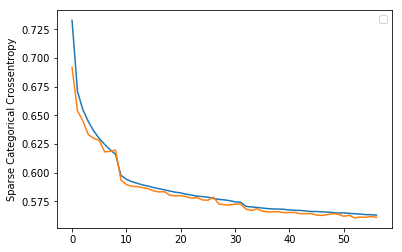

In [ ]:
plt.plot(hist[['loss', 'val_loss']])
plt.legend()
# plt.ylim([0, 10])
plt.ylabel('Sparse Categorical Crossentropy')

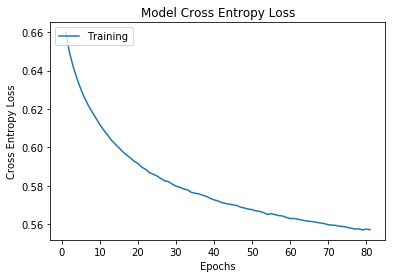

In [ ]:
sns.lineplot(x=range(1,+1),y=histor.history['loss'])
#sns.lineplot(x=range(1,EPOCHS+1),y=r.history['val_loss'])
plt.title('Model Cross Entropy Loss')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Epochs')
plt.legend(['Training'], loc='upper left')

In [ ]:
y_pred = res_net_model_walkforward.predict(X_test)

In [ ]:
y_pred_2 = res_net_model.predict(X_test)
print(y-PRED)

[[False False False]
 [False False False]
 [False False False]
 ...
 [False False False]
 [False False False]
 [False False False]]


In [ ]:
print(y_pred)
print(y_pred_2)

[[0.02278053 0.7124219  0.26479757]
 [0.01975996 0.80286896 0.177371  ]
 [0.01093824 0.70463616 0.28442565]
 ...
 [0.64936155 0.28116786 0.06947051]
 [0.5132548  0.43124154 0.05550363]
 [0.32671145 0.4160068  0.25728172]]
[[0.02355058 0.7283601  0.24808928]
 [0.0166661  0.8311667  0.15216723]
 [0.01317282 0.73877895 0.24804828]
 ...
 [0.64077836 0.28931198 0.06990956]
 [0.50623053 0.43926316 0.05450632]
 [0.3629744  0.42114305 0.21588255]]


In [ ]:
y_pred = res_net_model.predict(X_test)

In [ ]:
y_pred = y_pred.argmax(axis=1)

In [ ]:
np.unique(y_pred, return_counts=True), np.unique(y_test, return_counts=True)

((array([0, 1, 2]), array([ 94782, 277026,  93592])),
 (array([0, 1, 2]), array([ 61142, 350499,  53759])))

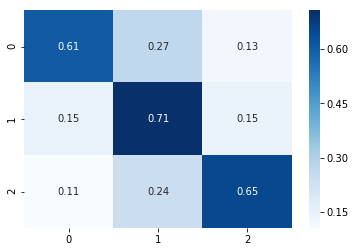

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
    
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

ax=sns.heatmap(cm, annot=True, xticklabels=[0,1,2], yticklabels=[0,1,2], cmap='Blues')
ax.set_ylim(3.0, 0)
plt.show()

In [ ]:
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

          0       0.39      0.61      0.48     61142
          1       0.89      0.71      0.79    350499
          2       0.37      0.65      0.47     53759

avg / total       0.77      0.69      0.71    465400



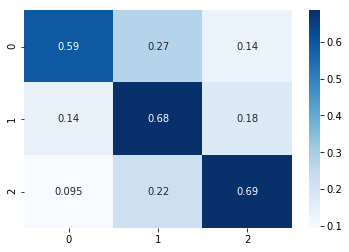

             precision    recall  f1-score   support

          0       0.40      0.59      0.48     61142
          1       0.89      0.68      0.78    350499
          2       0.35      0.69      0.46     53759

avg / total       0.77      0.67      0.70    465400



In [13]:
y_pred = res_net_model_walkforward.predict(X_test)

y_pred = y_pred.argmax(axis=1)

np.unique(y_pred, return_counts=True), np.unique(y_test, return_counts=True)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
    
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

ax=sns.heatmap(cm, annot=True, xticklabels=[0,1,2], yticklabels=[0,1,2], cmap='Blues')
ax.set_ylim(3.0, 0)
plt.show()

print(classification_report(y_test,y_pred))

In [64]:
average = np.zeros(int(len(y_test)/10))
print(average)
for i in range(int(len(y_test)/10)):
    if sum(y_test[i*10:(i+1)*10]) >= 5.0:
           average[i] = 1
print(average)

[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]


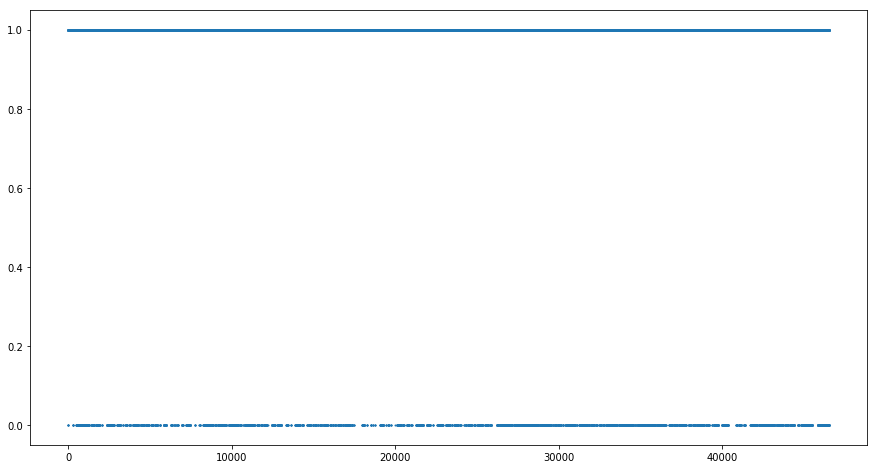

In [66]:
wrong = average == 0
correct = average == 1
plt.figure(figsize = (15,8))

plt.plot(average, marker='o', ls='', markersize=1.0)
plt.show()

312881 152519


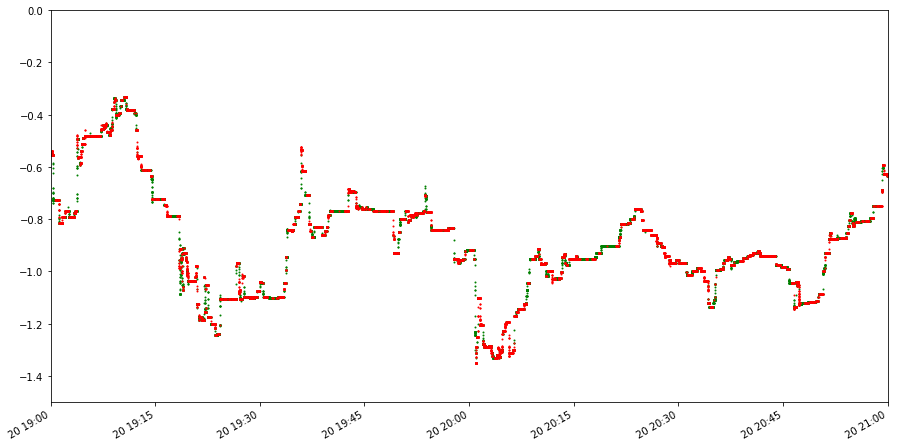

In [75]:
l2_train_val = l2_norm_adj[:-num_test]
l2_test = l2_norm_adj[-num_test:]

correct = l2_test[y_pred==y_test]
wrong = l2_test[y_pred!=y_test]
print(len(correct), len(wrong))

plt.figure(figsize = (15,8))

# plt.plot(l2_train_val.index, (l2_train_val['a1']+l2_train_val['b1'])/2, color="r", marker='o', markersize=12)
plt.plot(correct.index, (correct['a1']+correct['b1'])/2, color="g", marker='o', markersize=1, ls='')
plt.plot(wrong.index, (wrong['a1']+wrong['b1'])/2, color="r", marker='o', markersize=1, ls='')

plt.xlim(pd.Timestamp('2019-11-20 19:00:00'), pd.Timestamp('2019-11-20 21:00:00'))
plt.ylim(-1.5, 0)
plt.gcf().autofmt_xdate()

plt.show()

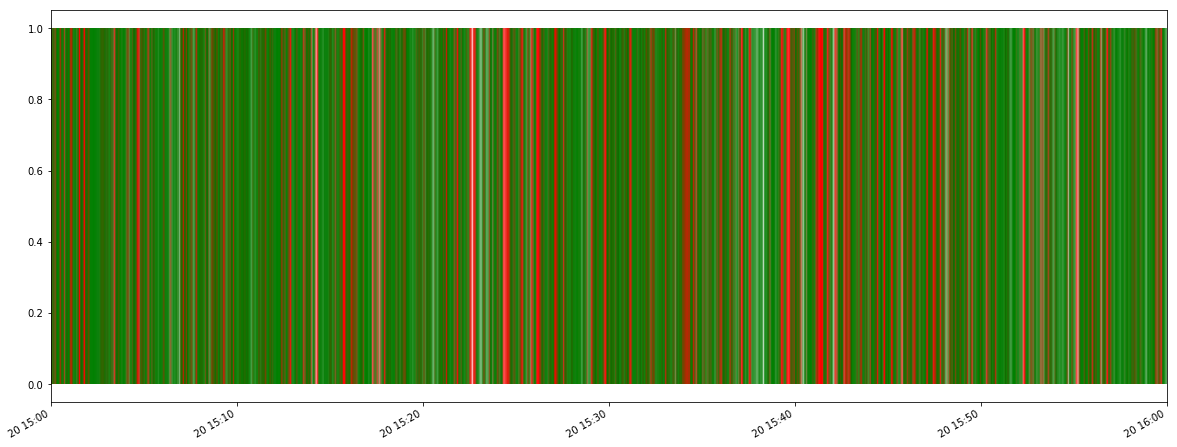

In [89]:
plt.figure(figsize = (20,8))

plt.xlim(pd.Timestamp('2019-11-20 15:00:00'), pd.Timestamp('2019-11-20 16:00:00'))
plt.vlines(wrong['2019-11-20 15:00:00':].index, 0, 1, color='r', lw=0.1)
plt.vlines(correct['2019-11-20 15:00:00':].index, 0, 1, color='g', lw=0.1)
plt.gcf().autofmt_xdate()


plt.show()

In [ ]:
df_history = pd.read_csv('history_training.csv', index_col=0)

In [ ]:
df_history.head()

,accuracy,loss,lr,val_accuracy,val_loss
0,0.662171,0.732915,0.001,0.685452,0.691871
1,0.697852,0.670754,0.001,0.704418,0.653910
2,0.705946,0.654831,0.001,0.710744,0.645040
3,0.711077,0.644557,0.001,0.717609,0.633086
4,0.715403,0.636243,0.001,0.718627,0.629828


No handles with labels found to put in legend.


Text(0, 0.5, 'Sparse Categorical Crossentropy')

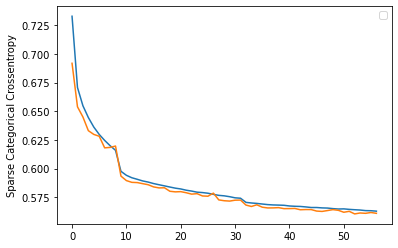

In [ ]:
plt.plot(df_history[['loss', 'val_loss']])
plt.legend()
# plt.ylim([0, 10])
plt.ylabel('Sparse Categorical Crossentropy')

No handles with labels found to put in legend.


Text(0, 0.5, 'Accuracy')

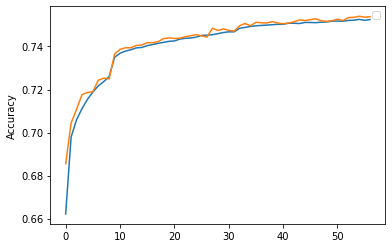

In [ ]:
plt.plot(df_history[['accuracy', 'val_accuracy']])
plt.legend()
# plt.ylim([0, 10])
plt.ylabel('Accuracy')